In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline
import matplotlib.ticker as ticker
import statsmodels.api as sm 
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA #模型

from statsmodels.stats.stattools import durbin_watson #DW检验
from statsmodels.graphics.api import qqplot #qq图

import itertools

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Preparation

In [ ]:
path = "/content/drive/My Drive/Python/OilProduction/37145_Prod_noNAN.csv"
df1 = pd.read_csv(path,
                #  na_values=[' ',0],
                 usecols=['FirstOfMonth','OilProduced'])
df1['FirstOfMonth']=pd.to_datetime(df1['FirstOfMonth'])
df1.set_index('FirstOfMonth',inplace=True)
df1

,OilProduced
FirstOfMonth,
2013-10-01,8339
2013-11-01,9566
2013-12-01,6654
2014-01-01,4951
2014-02-01,3849
...,...
2020-04-01,221
2020-05-01,216
2020-06-01,221


In [ ]:
df = pd.read_csv(path,
                #  na_values=[' ',0],
                 usecols=['FirstOfMonth','OilProduced'])
df['FirstOfMonth']=pd.to_datetime(df['FirstOfMonth'])
df

,FirstOfMonth,OilProduced
0,2013-10-01,8339
1,2013-11-01,9566
2,2013-12-01,6654
3,2014-01-01,4951
4,2014-02-01,3849
...,...,...
78,2020-04-01,221
79,2020-05-01,216
80,2020-06-01,221
81,2020-07-01,211


In [ ]:
# df1.index[58:]

DatetimeIndex(['2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01'],
              dtype='datetime64[ns]', name='FirstOfMonth', freq=None)

Text(0.5, 1.0, 'Oil Production')

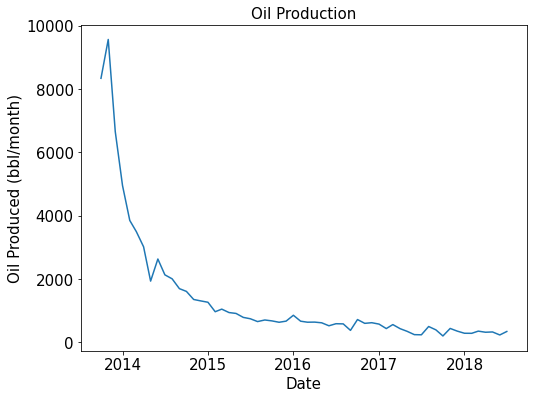

In [ ]:
ts=df1['OilProduced'][:58]
plt.figure(figsize=(8,6))

plt.plot(ts)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Oil Produced (bbl/month)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Oil Production',fontsize=15)


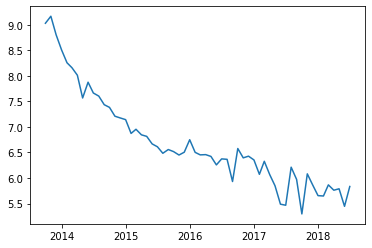

In [ ]:
ts_log=np.log(ts)
plt.plot(ts_log)

Text(0.5, 1.0, 'Transformed Time Series')

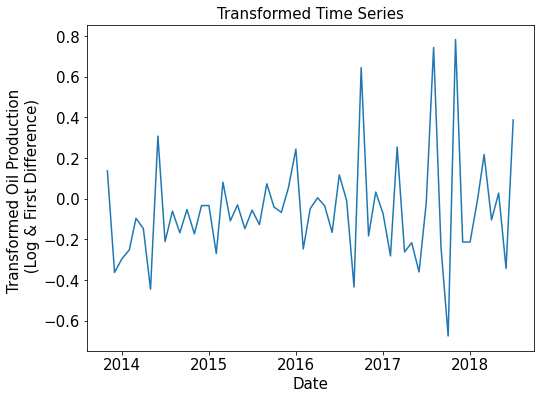

In [ ]:
ts_log_diff=ts_log.diff(1)
plt.figure(figsize=(8,6))
plt.plot(ts_log_diff)
# # ts_log_diff

plt.xlabel('Date',fontsize=15)
plt.ylabel('Transformed Oil Production \n (Log & First Difference)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Transformed Time Series',fontsize=15)


In [ ]:
# ts_log_diff=ts_log.diff(1)


# # fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
# # axes[0].plot(x1, y1)
# # axes[1].plot(x2, y2)
# # fig.tight_layout()

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
# axes[0].plot(ts)
# plt.xlabel('Date',fontsize=12)
# plt.ylabel('Oil Produced (bbl/day)',fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.title('Oil Production',fontsize=12)

# axes[1].plot(ts_log_diff)
# # ts_log_diff
# plt.xlabel('Date',fontsize=12)
# plt.ylabel('Transformed Oil Production \n (Log & First Difference)',fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.title('Stationary time series',fontsize=12)

# plt.tight_layout()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def rolling_statistics(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

def adf_test(timeseries):
    rolling_statistics(timeseries)#绘图
    print ('Results of Augment Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
def test_stationarity(timeseries):
    #Determing rolling statistics
    #计算移动平均，窗口大小为12 
    rolmean = timeseries.rolling(12).mean()
    #计算移动标准差，窗口大小为12
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
# ts_log_diff = ts_log - ts_log.shift(periods=1)
# # ts_log_diff=ts_log.diff(1)
# plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)

In [ ]:
# 差分操作,d代表差分序列，比如[1,1,1]可以代表3阶差分。  [12,1]可以代表第一次差分偏移量是12，第二次差分偏移量是1
def diff_ts(ts, d):
    global shift_ts_list
    #  动态预测第二日的值时所需要的差分序列
    global last_data_shift_list #这个序列在恢复过程中需要用到
    shift_ts_list = []
    last_data_shift_list = []
    tmp_ts = ts
    for i in d:
        last_data_shift_list.append(tmp_ts[-i])
        print (last_data_shift_list)
        shift_ts = tmp_ts.shift(i)
        shift_ts_list.append(shift_ts)
        tmp_ts = tmp_ts - shift_ts
    tmp_ts.dropna(inplace=True)
    return tmp_ts

# 还原操作
def predict_diff_recover(predict_value, d):
    if isinstance(predict_value, float):
        tmp_data = predict_value
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    elif isinstance(predict_value, np.ndarray):
        tmp_data = predict_value[0]
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    else:
        tmp_data = predict_value
        for i in range(len(d)):
            try:
                tmp_data = tmp_data.add(shift_ts_list[-i-1])
            except:
                raise ValueError('What you input is not pd.Series type!')
        tmp_data.dropna(inplace=True)
    return tmp_data # return np.exp(tmp_data)也可以return到最原始，tmp_data是对原始数据取对数的结果

In [ ]:
# from statsmodels.tsa.arima_model import ARIMA

# # ts_log_diff=ts_log_diff.dropna()

# model = ARIMA(ts_log,order=(1,1,0)) #第二个参数代表使用了一阶差分
# results_AR = model.fit(disp=-1)
# plt.plot(ts_log_diff)
# plt.plot(results_AR.fittedvalues, color='red') #红色线代表预测值
# plt.title('RSS:%.4f' % sum((results_AR.fittedvalues-ts_log_diff)**2))#残差平方和


Text(0.5, 1.0, 'R square: 0.22')

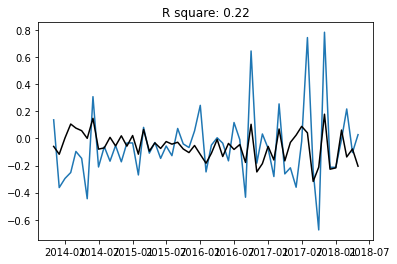

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

ts_log_diff=ts_log_diff.dropna()
#ARIMA
model = ARIMA(ts_log, order=(1, 1, 2))  #(1,1,2), RSS (4.9675), r2(0.31); (0, 1, 1) RSS (5.28), r2(0.26)
results_ARIMA = model.fit(disp=-1)  #不展示信息
plt.plot(ts_log_diff)
# plt.plot(results_ARIMA.fittedvalues, color='red')#和下面这句结果一样
plt.plot(results_ARIMA.predict(), color='black')#predict得到的就是fittedvalues，只是差分的结果而已。还需要继续回退
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
from sklearn.metrics import r2_score
plt.title('R square: %.2f'% r2_score(ts_log_diff,results_ARIMA.predict()))#

[5.834810737062605]
R square: 0.90
RMSE: 523.53
MAE: 248.80


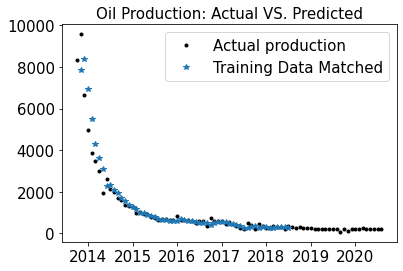

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

ts_log_diff = diff_ts(ts_log, d=[1])#调用差分方法，方便后续还原
model = ARIMA(ts_log, order=(0, 1, 1))  #建模, (0, 1, 1), r2=0.89
# model = ARIMA(ts_log, order=(1, 1, 2))  #建模, (1, 1, 2), r2=0.89; 
results_ARIMA = model.fit(disp=-1)  #fit
predict_ts = results_ARIMA.predict() #对训练数据进行预测

#还原
diff_recover_ts = predict_diff_recover(predict_ts, d=[1])#恢复数据
log_recover = np.exp(diff_recover_ts)#还原对数前数据

#绘图
from sklearn.metrics import mean_squared_error, mean_absolute_error

ts = ts[log_recover.index]#排除空的数据
# plt.figure(figsize=(12,8))

plt.plot(df1['OilProduced'],'.',color='black', label='Actual production')
plt.plot(log_recover,'*',label='Training Data Matched')
plt.legend(loc='best',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Oil Production: Actual VS. Predicted',fontsize=15)

# 'RMSE: %.2f'% np.sqrt(mean_squared_error(log_recover,ts)))#RMSE,残差平方和开根号，即标准差， (sp.mean((log_recover-ts) ** 2))
from sklearn.metrics import r2_score, mean_squared_error
print('R square: %.2f'% r2_score(ts,log_recover))#
print('RMSE: %.2f'% np.sqrt(mean_squared_error(log_recover,ts)))
print('MAE: %.2f'% mean_absolute_error(log_recover,ts))

# r2_score(y_true, y_pred)

# Predict

In [ ]:
forecast_n = 25 #预测未来25个月走势
forecast_ARIMA_log = results_ARIMA.forecast(forecast_n)
forecast_ARIMA_log = forecast_ARIMA_log[0]
print (forecast_ARIMA_log)

[5.61564446 5.55701768 5.49839089 5.43976411 5.38113732 5.32251054
 5.26388375 5.20525697 5.14663018 5.0880034  5.02937661 4.97074983
 4.91212304 4.85349626 4.79486947 4.73624269 4.6776159  4.61898912
 4.56036233 4.50173555 4.44310876 4.38448198 4.32585519 4.26722841
 4.20860162]


In [ ]:
# new_index = get_date_range('1961-01-01', forecast_n)
# new_index = range(48, 48+forecast_n)

from pandas import to_datetime
from pandas import DataFrame

future=df['FirstOfMonth'][58:]
future = DataFrame(future).reset_index(drop=True)
future.columns = ['FirstOfMonth']
future['FirstOfMonth']= to_datetime(future['FirstOfMonth'])
new_index=future['FirstOfMonth']

forecast_ARIMA_log = pd.Series(forecast_ARIMA_log, copy=True, index=new_index)
print (forecast_ARIMA_log)

FirstOfMonth
2018-08-01    5.615644
2018-09-01    5.557018
2018-10-01    5.498391
2018-11-01    5.439764
2018-12-01    5.381137
2019-01-01    5.322511
2019-02-01    5.263884
2019-03-01    5.205257
2019-04-01    5.146630
2019-05-01    5.088003
2019-06-01    5.029377
2019-07-01    4.970750
2019-08-01    4.912123
2019-09-01    4.853496
2019-10-01    4.794869
2019-11-01    4.736243
2019-12-01    4.677616
2020-01-01    4.618989
2020-02-01    4.560362
2020-03-01    4.501736
2020-04-01    4.443109
2020-05-01    4.384482
2020-06-01    4.325855
2020-07-01    4.267228
2020-08-01    4.208602
dtype: float64


FirstOfMonth
2018-08-01    274.690349
2018-09-01    259.049115
2018-10-01    244.298513
2018-11-01    230.387830
2018-12-01    217.269240
2019-01-01    204.897640
2019-02-01    193.230495
2019-03-01    182.227693
2019-04-01    171.851405
2019-05-01    162.065957
2019-06-01    152.837706
2019-07-01    144.134923
2019-08-01    135.927688
2019-09-01    128.187785
2019-10-01    120.888601
2019-11-01    114.005043
2019-12-01    107.513444
2020-01-01    101.391485
2020-02-01     95.618119
2020-03-01     90.173496
2020-04-01     85.038897
2020-05-01     80.196669
2020-06-01     75.630163
2020-07-01     71.323681
2020-08-01     67.262416
dtype: float64


Text(0.5, 1.0, 'forecast')

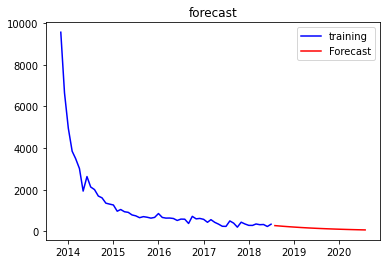

In [ ]:
# 直接取指数，即可恢复至原数据
forecast_ARIMA = np.exp(forecast_ARIMA_log)
print (forecast_ARIMA)
plt.plot(ts,label='training',color='blue')
plt.plot(forecast_ARIMA, label='Forecast',color='red')
plt.legend(loc='best')
plt.title('forecast')

Text(0.5, 1.0, 'Oil Production: Actual VS. Predicted (ARIMA)')

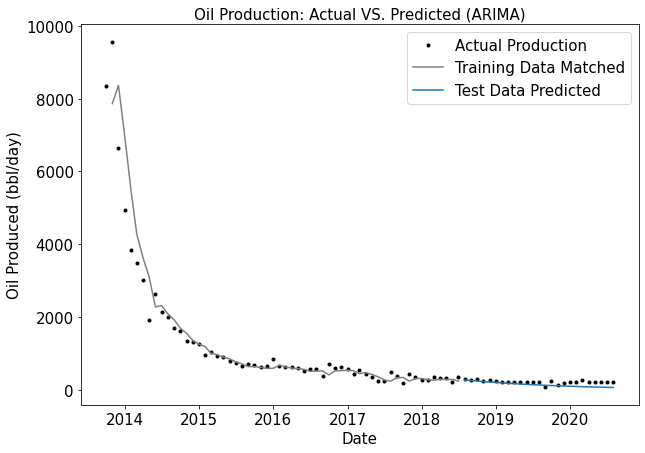

In [ ]:
# 绘图
from sklearn.metrics import mean_squared_error, mean_absolute_error

ts = ts[log_recover.index]#排除空的数据
plt.figure(figsize=(10,7))

plt.plot(df1['OilProduced'],'.',color='black', label='Actual Production')
plt.plot(log_recover,'-',color='gray',label='Training Data Matched')
plt.plot(forecast_ARIMA,'-',label='Test Data Predicted')
plt.legend(loc='best',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Oil Produced (bbl/day)',fontsize=15)

# ax = plt.axes()
# ax.set_ylim(0,1000)

plt.title('Oil Production: Actual VS. Predicted (ARIMA)',fontsize=15)

In [ ]:
print('train mae: %.2f' % mean_absolute_error(log_recover,ts))
print('train R square: %.2f'% r2_score(log_recover,ts))#
print('train RMSE: %.2f'% np.sqrt(mean_squared_error(log_recover,ts)))

print('test mae: %.2f' % mean_absolute_error(forecast_ARIMA,df1['OilProduced'][58:]))
print('test R square: %.2f'% r2_score(forecast_ARIMA,df1['OilProduced'][58:]))#
print('test RMSE: %.2f'% np.sqrt(mean_squared_error(forecast_ARIMA,df1['OilProduced'][58:])))

train mae: 248.80
train R square: 0.92
train RMSE: 523.53
test mae: 79.09
test R square: -1.28
test RMSE: 93.00


In [ ]:
# only predict one year
print('test 1-year mae: %.2f' % mean_absolute_error(forecast_ARIMA[:12],df1['OilProduced'][58:70]))
print('test R square: %.2f'% r2_score(forecast_ARIMA[:12],df1['OilProduced'][58:70]))#
print('test RMSE: %.2f'% np.sqrt(mean_squared_error(forecast_ARIMA[:12],df1['OilProduced'][58:70])))

test 1-year mae: 42.50
test R square: -0.32
test RMSE: 47.07


Order (1,1,2):
mae: 75.74
R square: -1.02
RMSE: 90.48

Order (0,1,1):
mae: 79.09
R square: -1.28
RMSE: 93.00

# others

构建模型和预测

In [ ]:
train_log_diff=ts_log_diff[:48]
test_log_diff=ts_log_diff[48:]

train_log=ts_log[:48]
test_log=ts_log[48:]

train=ts[:48]
test=ts[48:]

train_log

0     9.028699
1     9.165970
2     8.802973
3     8.507345
4     8.255569
5     8.159375
6     8.012018
7     7.566828
8     7.875119
9     7.664347
10    7.603399
11    7.435438
12    7.382746
13    7.210080
14    7.176255
15    7.142827
16    6.873164
17    6.954639
18    6.845880
19    6.815640
20    6.668228
21    6.612041
22    6.484635
23    6.558198
24    6.517671
25    6.450470
26    6.505784
27    6.749931
28    6.502790
29    6.453625
30    6.458338
31    6.423247
32    6.257668
33    6.375025
34    6.366470
35    5.932245
36    6.577861
37    6.395262
38    6.428105
39    6.354370
40    6.073045
41    6.327937
42    6.066108
43    5.849325
44    5.488938
45    5.468060
46    6.212606
47    5.973810
Name: OilProduced, dtype: float64

Text(0.5, 1.0, 'RSS:2.09')

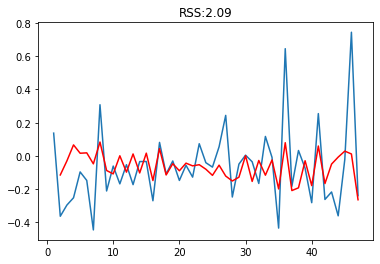

In [ ]:
model = ARIMA(train_log,(1,1,2)).fit(disp=-1)#第二个参数代表使用了一阶差分

plt.plot(train_log_diff)
plt.plot(model.predict(), color='red') #红色线代表预测值
plt.title('RSS:%.2f' % sum((model.fittedvalues-train_log_diff)**2))#残差平方和   #when using ts_log_diff, RSS=4.94, (0,1,3); RSS=5.02,(0,1,2);

In [ ]:
model.predict()

2    -0.114402
3    -0.029855
4     0.066556
5     0.016296
6     0.018646
7    -0.047491
8     0.083714
9    -0.087594
10   -0.107948
11    0.001020
12   -0.097548
13    0.011971
14   -0.102382
15    0.016813
16   -0.148006
17    0.044113
18   -0.114337
19   -0.046661
20   -0.089238
21   -0.043341
22   -0.059670
23   -0.052662
24   -0.079833
25   -0.116813
26   -0.055422
27   -0.120958
28   -0.150712
29   -0.127819
30    0.001540
31   -0.153207
32   -0.027313
33   -0.115862
34   -0.024170
35   -0.198407
36    0.079693
37   -0.208407
38   -0.191831
39   -0.028826
40   -0.178554
41    0.059726
42   -0.166142
43   -0.048928
44   -0.006936
45    0.029008
46    0.011931
47   -0.263697
dtype: float64

D-W检验值为1.9903724910377139


<Figure size 864x576 with 0 Axes>

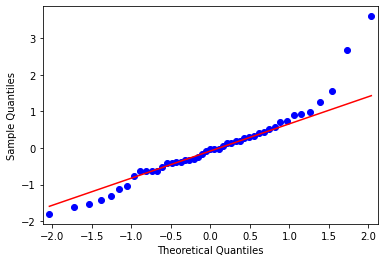

In [ ]:
#残差
resid = model.resid 
#利用QQ图检验残差是否满足正态分布
plt.figure(figsize=(12,8))
qqplot(resid,line='q',fit=True)
#利用D-W检验,检验残差的自相关性
print('D-W检验值为{}'.format(durbin_watson(resid.values)))

# 当D-W检验值接近于2时，不存在自相关性，说明模型较好。
#  D-W检验如何数学说明，可以参考下面链接。
#  https://wenku.baidu.com/view/57224dcfcf84b9d528ea7aba.html

Prediction

In [ ]:
# 差分操作,d代表差分序列，比如[1,1,1]可以代表3阶差分。  [12,1]可以代表第一次差分偏移量是12，第二次差分偏移量是1
def diff_ts(ts, d):
    global shift_ts_list
    #  动态预测第二日的值时所需要的差分序列
    global last_data_shift_list #这个序列在恢复过程中需要用到
    shift_ts_list = []
    last_data_shift_list = []
    tmp_ts = ts
    for i in d:
        last_data_shift_list.append(tmp_ts[-i])
        print last_data_shift_list
        shift_ts = tmp_ts.shift(i)
        shift_ts_list.append(shift_ts)
        tmp_ts = tmp_ts - shift_ts
    tmp_ts.dropna(inplace=True)
    return tmp_ts


# 还原操作
def predict_diff_recover(predict_value, d):
    if isinstance(predict_value, float):
        tmp_data = predict_value
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    elif isinstance(predict_value, np.ndarray):
        tmp_data = predict_value[0]
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    else:
        tmp_data = predict_value
        for i in range(len(d)):
            try:
                tmp_data = tmp_data.add(shift_ts_list[-i-1])
            except:
                raise ValueError('What you input is not pd.Series type!')
        tmp_data.dropna(inplace=True)
    return tmp_data # return np.exp(tmp_data)也可以return到最原始，tmp_data是对原始数据取对数的结果


In [ ]:
train_log_restored = pd.Series([train_log[0]], index=[train_log.index[0]]) .append(model.predict()).cumsum()
train_log_restored                              

0     9.028699
2     8.905538
3     8.895166
4     8.975153
5     8.991626
6     8.930652
7     8.834455
8     8.867216
9     8.718075
10    8.580371
11    8.549108
12    8.509615
13    8.473359
14    8.425244
15    8.361559
16    8.256223
17    8.244815
18    8.166026
19    8.069073
20    8.001623
21    7.950527
22    7.905290
23    7.850137
24    7.746127
25    7.632241
26    7.571710
27    7.476256
28    7.298069
29    7.252535
30    7.261503
31    7.182668
32    7.101265
33    7.058519
34    6.954195
35    6.826851
36    6.887425
37    6.669592
38    6.485148
39    6.463045
40    6.404542
41    6.459948
42    6.333566
43    6.251668
44    6.280601
45    6.325651
46    6.282745
47    5.881109
dtype: float64

Text(0.5, 1.0, 'RMSE: 2285.7162')

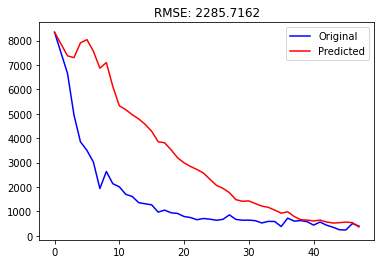

In [ ]:
# 还原
log_recover = np.exp(train_log_restored)#还原对数前数据

#绘图
ts = ts[log_recover.index]#排除空的数据
plt.plot(ts,color="blue",label='Original')
plt.plot(log_recover,color='red',label='Predicted')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/len(ts)))#RMSE,残差平方和开根号，即标准差

In [ ]:
forecast_n = 36 #预测未来36个月走势
forecast_ARIMA_log = model.forecast(forecast_n)
forecast_ARIMA_log = forecast_ARIMA_log[0]
print (forecast_ARIMA_log)

[5.7809346  5.86243267 5.82906968 5.76257987 5.69609006 5.62960026
 5.56311045 5.49662065 5.43013084 5.36364104 5.29715123 5.23066143
 5.16417162 5.09768182 5.03119201 4.9647022  4.8982124  4.83172259
 4.76523279 4.69874298 4.63225318 4.56576337 4.49927357 4.43278376
 4.36629396 4.29980415 4.23331434 4.16682454 4.10033473 4.03384493
 3.96735512 3.90086532 3.83437551 3.76788571 3.7013959  3.6349061 ]


48    5.780935
49    5.862433
50    5.829070
51    5.762580
52    5.696090
dtype: float64
48    324.061916
49    351.578378
50    340.042182
51    318.168103
52    297.701130
53    278.550747
54    260.632262
55    243.866428
56    228.179099
57    213.500898
58    199.766909
59    186.916394
60    174.892521
61    163.642115
62    153.115419
63    143.265880
64    134.049938
65    125.426834
66    117.358434
67    109.809054
68    102.745307
69     96.135954
70     89.951764
71     84.165387
72     78.751235
73     73.685361
74     68.945363
75     64.510277
76     60.360489
77     56.477647
78     52.844578
79     49.445216
80     46.264527
81     43.288444
82     40.503804
83     37.898294
dtype: float64


Text(0.5, 1.0, 'forecast')

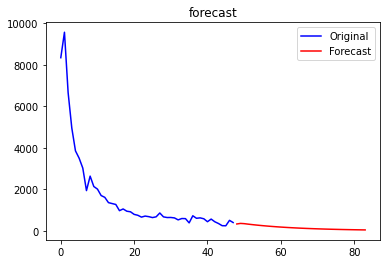

In [ ]:
# 预测从1961-01-01开始，也就是我们训练数据最后一个数据的后一个日期
# new_index = get_date_range('1961-01-01', forecast_n)
new_index = range(48, 48+forecast_n)
forecast_ARIMA_log = pd.Series(forecast_ARIMA_log, copy=True, index=new_index)
print (forecast_ARIMA_log.head())

# 直接取指数，即可恢复至原数据
forecast_ARIMA = np.exp(forecast_ARIMA_log)
print (forecast_ARIMA)
plt.plot(train,label='Original',color='blue')
plt.plot(forecast_ARIMA, label='Forecast',color='red')
plt.legend(loc='best')
plt.title('forecast')

Text(0.5, 1.0, 'Comparison')

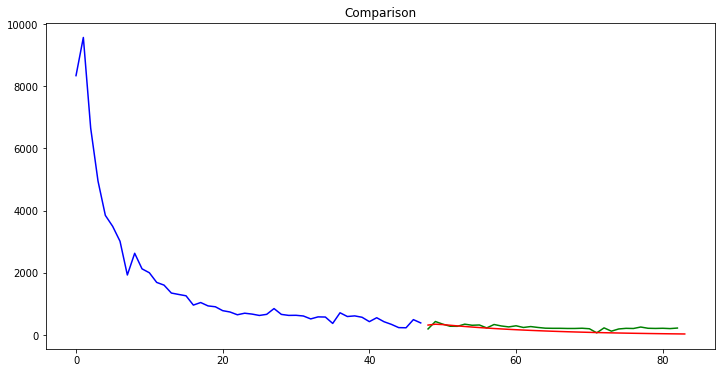

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train,color="blue") # 画出原来的时间序列图
plt.plot(test,color="green") # 画出原来的时间序列图
plt.plot(forecast_ARIMA, label='Forecast',color='red') # 画出原来的时间序列图


# plt.plot(test['pred'],color='red',linestyle='-.')# 画出预测的时间序列
plt.title("Comparison")

In [ ]:
# 一次一阶差分的恢复
import pandas as pd
time_series = pd.Series([2,4,3,5,6,7,4,5,6,3,2,4], index=pd.date_range(start='2000', periods=12, freq='a'))
time_series_diff = time_series.diff(1).dropna()

time_series_restored = pd.Series([time_series[0]], 
                                 index=[time_series.index[0]]) .append(time_series_diff).cumsum()

time_series.index[0]

Timestamp('2000-12-31 00:00:00', freq='A-DEC')

In [ ]:
time_series

2000-12-31    2
2001-12-31    4
2002-12-31    3
2003-12-31    5
2004-12-31    6
2005-12-31    7
2006-12-31    4
2007-12-31    5
2008-12-31    6
2009-12-31    3
2010-12-31    2
2011-12-31    4
Freq: A-DEC, dtype: int64

In [ ]:
## (6) 将差分后的数据还原为真实数据
last = train.loc[train.shape[0]-1,]['OilProduced']
pred = []
for i in pred_diff[0]:
    pred.append(last+i)
    last = last+i
test['pred'] = pred
test

,FirstOfMonth,OilProduced,pred
40,2017-02-01,434.0,1208.704723
41,2017-03-01,560.0,1593.752904
42,2017-04-01,431.0,1861.161227
43,2017-05-01,347.0,2005.105579
44,2017-06-01,242.0,2021.486257
45,2017-07-01,237.0,1908.564374
46,2017-08-01,499.0,1665.038630
47,2017-09-01,393.0,1290.395056
48,2017-10-01,200.0,784.218044
49,2017-11-01,438.0,146.357765


确定p d q，



1.   首先要确定 d，答：看序列要不要差分后才能平稳。
2.   其次确定 AR  MA  还是ARMA ？ 答：若平稳序列的偏相关函数是截尾的，而自相关函数是拖尾的，可断定序列适合AR模型；若平稳序列的偏相关函数是拖尾的，而自相关函数是截尾的，则可断定序列适合MA模型；若平稳序列的偏相关函数和自相关函数均是拖尾的，则序列适合ARMA模型。
3.   接下来，关键在于分清托尾、截尾的概念。答：相关函数值在k>q以后全部是0，称为截尾性；如果随着滞后期k的增加，函数值呈现指数或正弦波衰减，趋于0，称为拖尾性。
4.   说白了，什么是拖尾、什么是截尾？ 答：截尾就是前面只有孤立的长长一根，后面突然全没了。拖尾就是没有截干净的，后面杂七杂吧还有。（引自论坛某位高人语录）
5.  确定AR  MA  还是ARMA 后，第三，才是确定p、q。答：看拖尾部分，有几根在可信区间外，偏自相关确定p，自相关确定q。（第三点是我自己体会，可能有错），多组合组合，根据软件计算的结果来确定模型的优劣。


Reference:

http://xtf615.com/2017/03/08/Python%E5%AE%9E%E7%8E%B0%E6%97%B6%E9%97%B4%E5%BA%8F%E5%88%97%E5%88%86%E6%9E%90/